# Quora Question Pairs

In [60]:
# 모듈 불러 오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

import re
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
import pickle

from sklearn.model_selection import train_test_split
import xgboost as xgb

from IPython.display import SVG
from keras.utils import model_to_dot
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D, Concatenate
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from gensim.models import fasttext
from gensim.test.utils import datapath

In [24]:
# 경로 설정
root_path = "/content/drive/My Drive/멀티캠퍼스/[혁신성장] 인공지능 자연어처리 기반/[강의]/조성현 강사님"
data_path = f"{root_path}/dataset"

In [25]:
# 데이터 로드
data = pd.read_csv(f"{data_path}/5-1.questions.csv")
data.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## _1_. EDA

In [4]:
# 두 질문을 하나로 합치기
train_set = pd.Series(data['question1'].tolist() + 
                      data['question2'].tolist()).astype(str)
train_set.head()

0    What is the step by step guide to invest in sh...
1    What is the story of Kohinoor (Koh-i-Noor) Dia...
2    How can I increase the speed of my internet co...
3    Why am I mentally very lonely? How can I solve...
4    Which one dissolve in water quikly sugar, salt...
dtype: object

In [13]:
# 데이터 중복 질문 개수 파악
print(f"총 질문 수: {len(np.unique(train_set))}")
print(f"반복 질문수: {np.sum(train_set.value_counts() > 1)}")

총 질문 수: 537388
반복 질문수: 111894


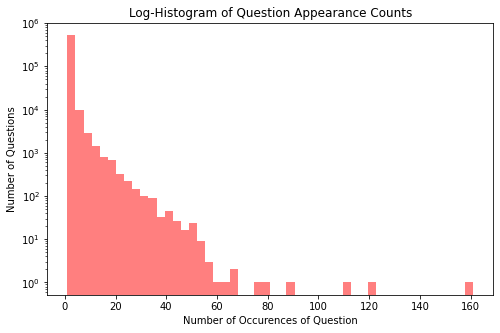

In [15]:
# 각 질문별 출현 빈도 로그 히스토그램으로 표현
plt.figure(figsize=(8, 5))
plt.hist(train_set.value_counts(), bins=50, alpha=0.5, color='r', label='word')
plt.yscale('log', nonposy='clip') # y값이 0보다 작은 애들 clip
plt.title('Log-Histogram of Question Appearance Counts')
plt.xlabel('Number of Occurences of Question')
plt.ylabel('Number of Questions')
plt.show()

In [20]:
# 중복 질문 각 통계량 확인
print(f'중복 최대 개수: {np.max(train_set.value_counts())}')
print(f'중복 최소 개수: {np.min(train_set.value_counts())}')
print(f'중복 평균 개수: {np.mean(train_set.value_counts())}')
print(f'중복 표준편차: {np.std(train_set.value_counts())}')
print(f'중복 중간길이: {np.median(train_set.value_counts())}')
print(f'제 1 사분위 중복: {np.percentile(train_set.value_counts(), 25)}')
print(f'제 3 사분위 중복: {np.percentile(train_set.value_counts(), 75)}')

pd.DataFrame(train_set.value_counts()).describe()

중복 최대 개수: 161
중복 최소 개수: 1
중복 평균 개수: 1.5048754345091442
중복 표준편차: 1.911654109807301
중복 중간길이: 1.0
제 1 사분위 중복: 1.0
제 3 사분위 중복: 1.0


,0
count,537388.000000
mean,1.504875
std,1.911656
min,1.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,161.000000


박스 플롯을 그려 본 결과, 중복 횟수 이상치가 너무 많다.

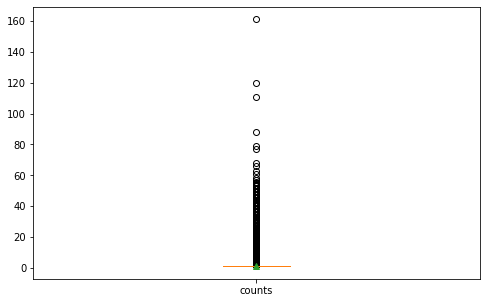

In [21]:
# 각 질문 중복 개수에 대해 박스플롯 그려 보기
plt.figure(figsize=(8, 5))
plt.boxplot([train_set.value_counts()], labels=['counts'], showmeans=True)
plt.show()

(-0.5, 799.5, 599.5, -0.5)

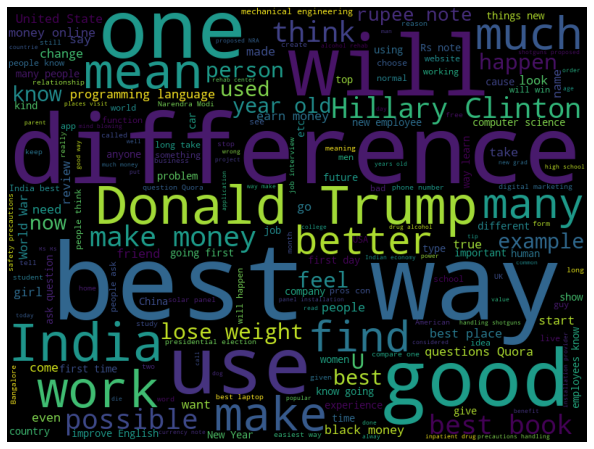

In [23]:
# 데이터에 어떤 단어가 포함되어 있는지 워드클라우드로 살펴 보기
cloud = WordCloud(width=800, height=600).generate(" ".join(train_set.astype(str)))
plt.figure(figsize=(12, 8))
plt.imshow(cloud)
plt.axis('off')

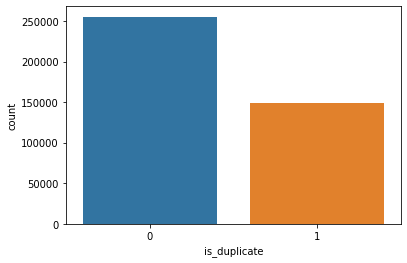

In [27]:
# 0, 1별로 
# fig, axes = plt.subplots(ncols=1)
# fig.set_size_inches(6, 3)
sns.countplot(data['is_duplicate'])
plt.show()

Text(0, 0.5, 'Probability')

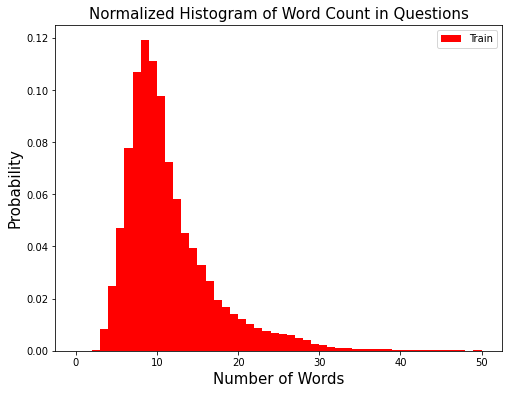

In [28]:
# 띄어쓰기 기준 단어의 개수
train_word_counts = train_set.apply(lambda x:len(x.split(' ')))
plt.figure(figsize=(8, 6))
plt.hist(train_word_counts, bins=50, range=[0, 50], facecolor='r', density=True, label='Train')
plt.title('Normalized Histogram of Word Count in Questions', fontsize=15)
plt.legend()
plt.xlabel('Number of Words', fontsize=15)
plt.ylabel('Probability', fontsize=15)

In [29]:
# 단어 개수별 통계량 확인
print('질문 단어 개수 최대 값: {}'.format(np.max(train_word_counts)))
print('질문 단어 개수 평균 값: {:.2f}'.format(np.mean(train_word_counts)))
print('질문 단어 개수 표준편차: {:.2f}'.format(np.std(train_word_counts)))
print('질문 단어 개수 중간 값: {}'.format(np.median(train_word_counts)))
print('질문 단어 개수 제 1 사분위: {}'.format(np.percentile(train_word_counts, 25)))
print('질문 단어 개수 제 3 사분위: {}'.format(np.percentile(train_word_counts, 75)))
print('질문 단어 개수 99 퍼센트: {}'.format(np.percentile(train_word_counts, 99)))

질문 단어 개수 최대 값: 237
질문 단어 개수 평균 값: 11.06
질문 단어 개수 표준편차: 5.89
질문 단어 개수 중간 값: 10.0
질문 단어 개수 제 1 사분위: 7.0
질문 단어 개수 제 3 사분위: 13.0
질문 단어 개수 99 퍼센트: 31.0


### ==== 테스트 ====

In [11]:
train_set.value_counts()

What are the best ways to lose weight?                                                            161
How can you look at someone's private Instagram account without following them?                   120
How can I lose weight quickly?                                                                    111
What's the easiest way to make money online?                                                       88
Can you see who views your Instagram?                                                              79
                                                                                                 ... 
How is the structure of a protein different from the structure of a nucleic acid?                   1
Where can I buy good quality car covers in US?                                                      1
Does moisturizer get rid of wrinkles?                                                               1
When did Subhash Chandra Bose die?                                                

## _2_. 전처리

In [26]:
# 중복된 데이터와 중복되지 않은 질문 데이터로 분리
train_pos_data = data.loc[data['is_duplicate'] == 1]
train_neg_data = data.loc[data['is_duplicate'] == 0]

샘플링을 통해 두 라벨에 해당하는 데이터 개수가 갖도록 만들어 준다.

In [27]:
# 중복되지 않은 질문의 개수가 더 적으므로, 샘플링
sample_frac = len(train_pos_data) / len(train_neg_data)
print(f"샘플링 전 1/0 비율: {sample_frac}")
train_neg_data = train_neg_data.sample(frac=sample_frac) # 0 데이터에서 1만큼 샘플링.
print(f"샘플링 후 1/0 비율: {len(train_pos_data) / len(train_neg_data)}")

샘플링 전 1/0 비율: 0.5854104177694133
샘플링 후 1/0 비율: 1.0


In [28]:
# 두 데이터를 확인 후, 합친다.
display(train_pos_data.head())
display(train_neg_data.head())

train_data = pd.concat([train_neg_data, train_pos_data])
display(train_data)

,id,qid1,qid2,question1,question2,is_duplicate
5,5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1
7,7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1
11,11,23,24,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1
12,12,25,26,What can make Physics easy to learn?,How can you make physics easy to learn?,1
13,13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1


,id,qid1,qid2,question1,question2,is_duplicate
28688,28688,57199,57200,What is the package for freshers in Secureye?,What is the package offered by ABCO Advisary S...,0
130091,130091,257671,257672,What's it like to study A-levels at home?,What does studying A-level do?,0
105546,105546,209350,209351,What is Special about this Bollywood Personali...,How do you think banning Pakistani artists gon...,0
240266,240266,473255,473256,Does taking NSAIDs after a flu shot reduce the...,What are the disadvantages of getting flu and ...,0
108712,108712,215588,215589,Which are top five mutual funds in India based...,What are top five companies to invest in mutua...,0


,id,qid1,qid2,question1,question2,is_duplicate
28688,28688,57199,57200,What is the package for freshers in Secureye?,What is the package offered by ABCO Advisary S...,0
130091,130091,257671,257672,What's it like to study A-levels at home?,What does studying A-level do?,0
105546,105546,209350,209351,What is Special about this Bollywood Personali...,How do you think banning Pakistani artists gon...,0
240266,240266,473255,473256,Does taking NSAIDs after a flu shot reduce the...,What are the disadvantages of getting flu and ...,0
108712,108712,215588,215589,Which are top five mutual funds in India based...,What are top five companies to invest in mutua...,0
...,...,...,...,...,...,...
404341,404341,789782,789783,What are some outfit ideas to wear to a frat p...,What are some outfit ideas wear to a frat them...,1
404342,404342,789784,789785,Why is Manaphy childish in Pokémon Ranger and ...,Why is Manaphy annoying in Pokemon ranger and ...,1
404343,404343,789786,789787,How does a long distance relationship work?,How are long distance relationships maintained?,1
404345,404345,789790,789791,What does Jainism say about homosexuality?,What does Jainism say about Gays and Homosexua...,1


In [29]:
# q1, q2 문자열로
q1 = [str(s) for s in train_data['question1']]
q2 = [str(s) for s in train_data['question2']]
len(q1), len(q2)

(298612, 298612)

In [30]:
# 간단한 전처리
puncs = "([~.,!?\"':;)(])"
filtered_q1 = []
filtered_q2 = []
for q1_, q2_, in zip(q1, q2):
    filtered_q1.append(re.sub(re.compile(puncs), "", q1_).lower()) # 제거 후 소문자
    filtered_q2.append(re.sub(re.compile(puncs), "", q2_).lower()) # 제거 후 소문자 -

In [42]:
# 전처리한 파일 pickle로 저장
with open(f"{data_path}/train_Q1_preprocessed.pickle", "wb") as f:
    pickle.dump(filtered_q1, f)
    
with open(f"{data_path}/train_Q2_preprocessed.pickle", "wb") as f:
    pickle.dump(filtered_q2, f)

In [31]:
# 어휘집 생성 및 단어 워드 인덱스 변환
tokenizer = Tokenizer()
tokenizer.fit_on_texts(filtered_q1 + filtered_q2) # 두 물음 각각에 대해 fit
q1_sequences = tokenizer.texts_to_sequences(filtered_q1)
q2_sequences = tokenizer.texts_to_sequences(filtered_q2)

In [33]:
# 어휘집 및 시퀀스 확인
print(list(tokenizer.word_index)[:20])
print(q1_sequences[0])
print(q2_sequences[0])

['the', 'what', 'is', 'how', 'i', 'to', 'a', 'in', 'do', 'of', 'are', 'and', 'can', 'for', 'you', 'why', 'best', 'my', 'it', 'on']
[2, 3, 1, 1637, 14, 3119, 8, 45138]
[2, 3, 1, 1637, 2740, 57, 62128, 62129, 455, 6, 7, 1430]


In [34]:
# 토크나이저 객체 저장
with open(f"{data_path}/5-2.Quora-tokenizer.pickle", "wb") as f:
    pickle.dump(tokenizer, f)

In [48]:
# 문장 패딩
def check_len(threshold, sentences):
    cnt = 0
    for sent in sentences:
        if len(sent) <= threshold:
            cnt += 1
    return f'전체 문장 중 길이가 {threshold} 이하인 샘플의 비율: {(cnt/len(sentences))*100}'

for i in range(10, 40):
    print(check_len(i, q1_sequences + q2_sequences))

전체 문장 중 길이가 10 이하인 샘플의 비율: 60.63085207560312
전체 문장 중 길이가 11 이하인 샘플의 비율: 67.87001192182498
전체 문장 중 길이가 12 이하인 샘플의 비율: 73.65511098013475
전체 문장 중 길이가 13 이하인 샘플의 비율: 78.17770216870052
전체 문장 중 길이가 14 이하인 샘플의 비율: 82.03722556360763
전체 문장 중 길이가 15 이하인 샘플의 비율: 85.22715095173669
전체 문장 중 길이가 16 이하인 샘플의 비율: 87.80189677574913
전체 문장 중 길이가 17 이하인 샘플의 비율: 89.6432494340482
전체 문장 중 길이가 18 이하인 샘플의 비율: 91.24482606191312
전체 문장 중 길이가 19 이하인 샘플의 비율: 92.59406855719126
전체 문장 중 길이가 20 이하인 샘플의 비율: 93.74506047981997
전체 문장 중 길이가 21 이하인 샘플의 비율: 94.67050888778749
전체 문장 중 길이가 22 이하인 샘플의 비율: 95.52780866140678
전체 문장 중 길이가 23 이하인 샘플의 비율: 96.19389039958207
전체 문장 중 길이가 24 이하인 샘플의 비율: 96.80488392964783
전체 문장 중 길이가 25 이하인 샘플의 비율: 97.34923579762366
전체 문장 중 길이가 26 이하인 샘플의 비율: 97.88035979799874
전체 문장 중 길이가 27 이하인 샘플의 비율: 98.3450095776459
전체 문장 중 길이가 28 이하인 샘플의 비율: 98.70232944422864
전체 문장 중 길이가 29 이하인 샘플의 비율: 98.9350729374573
전체 문장 중 길이가 30 이하인 샘플의 비율: 99.12294214566059
전체 문장 중 길이가 31 이하인 샘플의 비율: 99.26945333744122
전체 문장 중 길이가 3

In [35]:
MAX_LENGTH = int(input('문장 최대 길이 설정: '))
q1_data = pad_sequences(q1_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')
q2_data = pad_sequences(q2_sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

문장 최대 길이 설정: 31


In [36]:
# 데이터 저장
train_labels = np.array(train_data['is_duplicate'], dtype=int)

np.save(open(f"{data_path}/5-2.train_q1.npy", 'wb'), q1_data)
np.save(open(f"{data_path}/5-2.train_q2.npy", 'wb'), q2_data)
np.save(open(f"{data_path}/5-2.train_label.npy", 'wb'), train_labels)

## _3_. 모델링

### 3.1. XGBoost

책에서는 3차원 array로 만들었으나, 강사님 코드에서는 2차원으로 데이터를 만들었다.

- 책: `np.hstack((q1_data, q2_data), axis=1)`


In [55]:
# 데이터 결합
train_data = np.hstack((q1_data, q2_data))
train_data.shape

(298612, 62)

In [58]:
# 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(train_data, train_labels,
                                                    test_size=0.2,
                                                    random_state=42)

In [60]:
# XGBoost 형태에 맞게 변경
X_train = xgb.DMatrix(X_train, y_train)
X_test = xgb.DMatrix(X_test, y_test)
data_list = [(X_train, 'Train'), (X_test, 'Validation')]

In [61]:
# XGBoost 파라미터 설정
params_ = {
    'eta': 0.3,
    'max_depth': 3,
    'objective': 'binary:logistic',
    'eval_metric': 'rmse'
} 

In [62]:
# 모델 학습
model = xgb.train(params=params_, dtrain=X_train,
                  num_boost_round=1000,
                  evals=data_list)

[0]	Train-rmse:0.491892	Validation-rmse:0.491608
[1]	Train-rmse:0.487252	Validation-rmse:0.486499
[2]	Train-rmse:0.483387	Validation-rmse:0.48273
[3]	Train-rmse:0.480014	Validation-rmse:0.47926
[4]	Train-rmse:0.477106	Validation-rmse:0.476238
[5]	Train-rmse:0.474598	Validation-rmse:0.47363
[6]	Train-rmse:0.472559	Validation-rmse:0.471708
[7]	Train-rmse:0.470259	Validation-rmse:0.469285
[8]	Train-rmse:0.468245	Validation-rmse:0.467384
[9]	Train-rmse:0.466697	Validation-rmse:0.46575
[10]	Train-rmse:0.464774	Validation-rmse:0.463838
[11]	Train-rmse:0.463661	Validation-rmse:0.462803
[12]	Train-rmse:0.462624	Validation-rmse:0.461738
[13]	Train-rmse:0.46153	Validation-rmse:0.460679
[14]	Train-rmse:0.460156	Validation-rmse:0.459336
[15]	Train-rmse:0.459178	Validation-rmse:0.458214
[16]	Train-rmse:0.458174	Validation-rmse:0.45721
[17]	Train-rmse:0.457569	Validation-rmse:0.45663
[18]	Train-rmse:0.45691	Validation-rmse:0.456052
[19]	Train-rmse:0.456162	Validation-rmse:0.455347
[20]	Train-rmse:0.

In [64]:
# 테스트 데이터로 정확도 예측
y_pred = model.predict(X_test)
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7549855164676925


### 3.2. (샴) CNN
- 교재에 나온 대로 `Siamese-CNN`을 구성하나, 임베딩 레이어를 공통으로 구성한다.



In [75]:
# 데이터 분리
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(q1_data, q2_data, train_labels,
                                                                             test_size=0.2,
                                                                             random_state=42)

In [68]:
# CNN 네트워크 파라미터
vocab_size = np.max([q1_data, q2_data]) + 1 # 패딩용 추가
EMB_SIZE = int(input('임베딩 차원 설정: '))
n_kernel =  int(input('컨볼루션 필터 사이즈 설정: '))

임베딩 차원 설정: 16
컨볼루션 필터 사이즈 설정: 32


========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 16)       1223648     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 16)       

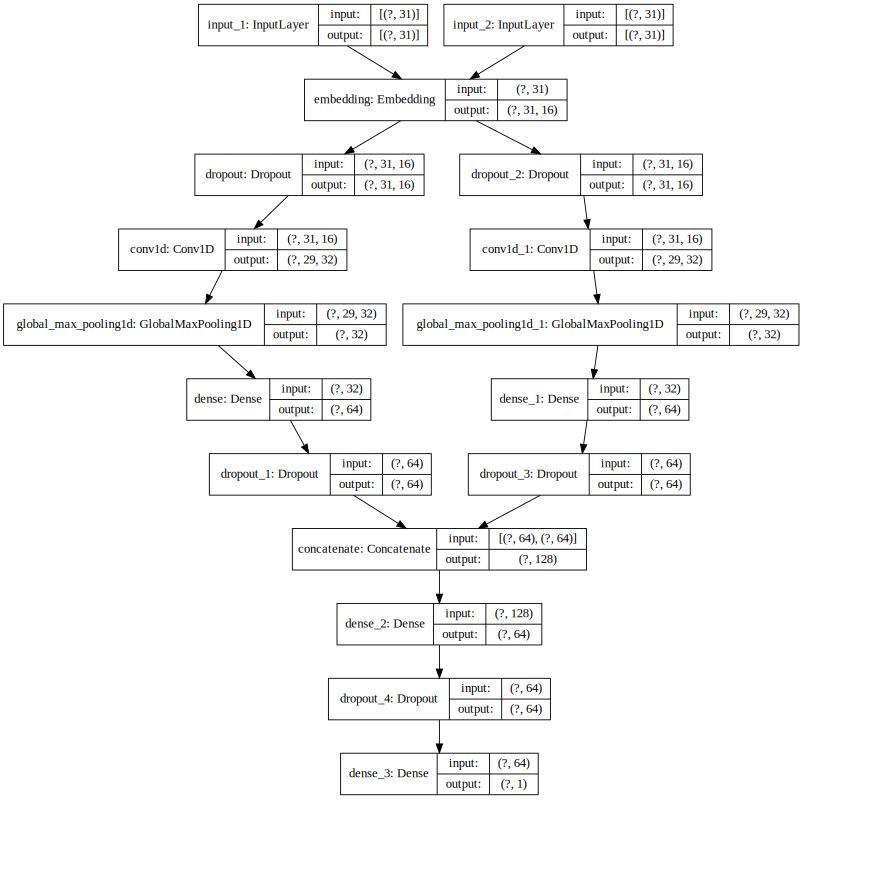

In [86]:
K.clear_session()

# CNN 네트워크 구성
X_input_1 = Input(batch_shape=(None, X_train_1.shape[1]))
X_input_2 = Input(batch_shape=(None, X_train_2.shape[1]))

X_embed = Embedding(input_dim = vocab_size, output_dim = EMB_SIZE) # 공통 임베딩 네트워크

X_embed_1 = X_embed(X_input_1)
X_embed_1 = Dropout(0.2)(X_embed_1)
X_conv_1 = Conv1D(filters=n_kernel, kernel_size=3, activation='relu')(X_embed_1)
X_pool_1 = GlobalMaxPool1D()(X_conv_1)
X_dense_1 = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(X_pool_1)
X_dense_1 = Dropout(0.2)(X_dense_1)

X_embed_2 = X_embed(X_input_2)
X_embed_2 = Dropout(0.2)(X_embed_2)
X_conv_2 = Conv1D(filters=n_kernel, kernel_size=3, activation='relu')(X_embed_2)
X_pool_2 = GlobalMaxPool1D()(X_conv_2)
X_dense_2 = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(X_pool_2)
X_dense_2 = Dropout(0.2)(X_dense_2)

X_concat = Concatenate()([X_dense_1, X_dense_2])
X_hidden = Dense(64, activation='relu', kernel_regularizer=l2(0.005))(X_concat)
X_hidden = Dropout(0.2)(X_hidden)
y_output = Dense(1, activation='sigmoid')(X_hidden)

# 모델 구성
model = Model([X_input_1, X_input_2], y_output)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0005))
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [87]:
# 모델 학습
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
hist = model.fit([X_train_1, X_train_2], y_train,
                 validation_data=([X_test_1, X_test_2], y_test),
                 batch_size=1000,
                 epochs=20)

Epoch 1/20
239/239 [==============================] - 20s 82ms/step - loss: 1.0589 - val_loss: 0.7250
Epoch 2/20
239/239 [==============================] - 19s 78ms/step - loss: 0.6281 - val_loss: 0.5760
Epoch 3/20
239/239 [==============================] - 18s 77ms/step - loss: 0.5387 - val_loss: 0.5504
Epoch 4/20
239/239 [==============================] - 18s 77ms/step - loss: 0.5052 - val_loss: 0.5460
Epoch 5/20
239/239 [==============================] - 18s 77ms/step - loss: 0.4833 - val_loss: 0.5481
Epoch 6/20
239/239 [==============================] - 18s 76ms/step - loss: 0.4649 - val_loss: 0.5527
Epoch 7/20
239/239 [==============================] - 18s 77ms/step - loss: 0.4486 - val_loss: 0.5611
Epoch 8/20
239/239 [==============================] - 19s 79ms/step - loss: 0.4339 - val_loss: 0.5619
Epoch 9/20
239/239 [==============================] - 19s 79ms/step - loss: 0.4211 - val_loss: 0.5673
Epoch 10/20
239/239 [==============================] - 19s 78ms/step - loss: 0.409

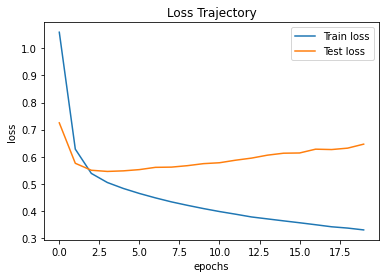

In [88]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss Trajectory")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [89]:
# 예측 및 결과 확인
y_pred = model.predict([X_test_1, X_test_2])
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7364499439077072


### 3.3. maLSTM
- 임베딩 레이어를 공통으로 구성한다.
- LSTM 네트워크를 통과한 후 각각의 latent feature 간 유클리디안 거리를 측정한다. 이를 유사도 측정의 기준으로 삼는다.
- 유클리디안 거리를 측정하기 위해 `backend` 기능을 사용한다.
- 유클리디안 거리의 기준을 0.5로 삼아도 되는가에 대한 질문이 있었다.


In [90]:
# 데이터 분리
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(q1_data, q2_data, train_labels,
                                                                             test_size=0.2,
                                                                             random_state=42)

In [91]:
# LSTM 네트워크 파라미터
vocab_size = np.max([q1_data, q2_data]) + 1 # 패딩용 추가
EMB_SIZE = int(input('임베딩 차원 설정: '))
n_hidden =  int(input('은닉 노드 수 설정: '))
n_feature = int(input('latent feature 차원 수 설정: '))

임베딩 차원 설정: 16
은닉 노드 수 설정: 10
latent feature 차원 수 설정: 10


========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 16)       1223648     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 16)       

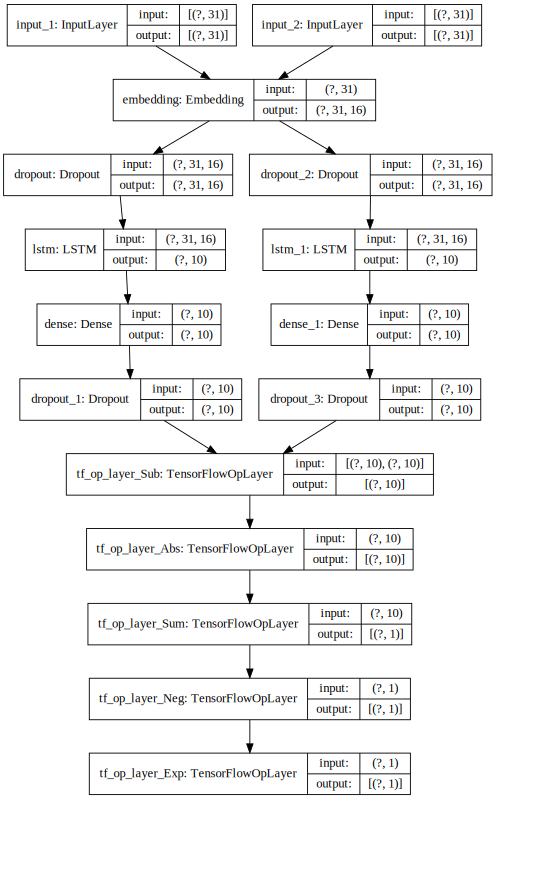

In [94]:
K.clear_session()

# LSTM 네트워크 구성
X_input_1 = Input(batch_shape=(None, X_train_1.shape[1]))
X_input_2 = Input(batch_shape=(None, X_train_2.shape[1]))

X_embed = Embedding(input_dim = vocab_size, output_dim = EMB_SIZE)

X_embed_1 = X_embed(X_input_1)
X_embed_1 = Dropout(0.2)(X_embed_1)
X_lstm_1 = LSTM(n_hidden)(X_embed_1)
X_dense_1 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_1)
X_dense_1 = Dropout(0.2)(X_dense_1)

X_embed_2 = X_embed(X_input_2)
X_embed_2 = Dropout(0.2)(X_embed_2)
X_lstm_2 = LSTM(n_hidden)(X_embed_2)
X_dense_2 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_2)
X_dense_2 = Dropout(0.2)(X_dense_2)

y_manhattan_dist = K.exp(-K.sum(K.abs(X_dense_1 - X_dense_2), axis=1, keepdims=True)) # 각 출력으로 맨하탄 거리 계산

# 모델 구성
model = Model([X_input_1, X_input_2], y_manhattan_dist)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0005))
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [95]:
# 모델 학습
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
hist = model.fit([X_train_1, X_train_2], y_train,
                 validation_data=([X_test_1, X_test_2], y_test),
                 batch_size=1000,
                 epochs=20)

Epoch 1/20
239/239 [==============================] - 23s 95ms/step - loss: 0.3499 - val_loss: 0.2805
Epoch 2/20
239/239 [==============================] - 22s 91ms/step - loss: 0.2459 - val_loss: 0.2169
Epoch 3/20
239/239 [==============================] - 22s 91ms/step - loss: 0.1998 - val_loss: 0.1949
Epoch 4/20
239/239 [==============================] - 22s 91ms/step - loss: 0.1750 - val_loss: 0.1831
Epoch 5/20
239/239 [==============================] - 22s 92ms/step - loss: 0.1598 - val_loss: 0.1832
Epoch 6/20
239/239 [==============================] - 22s 91ms/step - loss: 0.1497 - val_loss: 0.1829
Epoch 7/20
239/239 [==============================] - 22s 92ms/step - loss: 0.1424 - val_loss: 0.1830
Epoch 8/20
239/239 [==============================] - 22s 91ms/step - loss: 0.1381 - val_loss: 0.1850
Epoch 9/20
239/239 [==============================] - 22s 91ms/step - loss: 0.1343 - val_loss: 0.1874
Epoch 10/20
239/239 [==============================] - 22s 92ms/step - loss: 0.131

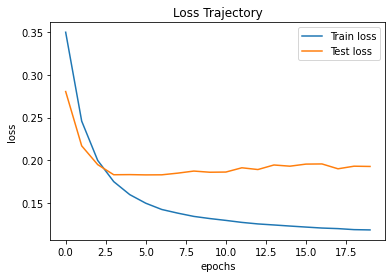

In [96]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss Trajectory")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [97]:
# 예측 및 결과 확인
y_pred = model.predict([X_test_1, X_test_2])
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7412722066875408


### 3.4. maLSTM + GlovePretrained

- Quora 데이터셋의 vocabulary 활용: `5.2` 전처리 단계에서 진행했던 tokenizer의 `word_index`.

- 가중치 벡터 만들 때
    - Glove.txt 파일 원래 생김새

    ```
    , -0.082752 0.67204 -0.14987 -0.064983 0.056491 0.40228 0.0027747 -0.3311 -0.30691 2.0817 0.031819 0.013643 0.30265 0.0071297 -0.5819 -0.2774 -0.062254 1.1451 -0.24232 0.1235 -0.12243 0.33152 -0.006162 -0.30541 -0.13057 -0.054601 0.037083 -0.070552 0.5893 -0.30385 0.2898 -0.14653 -0.27052 0.37161 0.32031 -0.29125 0.0052483 -0.13212 -0.052736 0.087349 -0.26668 -0.16897 0.015162 -0.0083746 -0.14871 0.23413 -0.20719 -0.091386 0.40075 -0.17223 0.18145 0.37586 -0.28682 0.37289 -0.16185 0.18008 0.3032 -0.13216 0.18352 0.095759 0.094916 0.008289 0.11761 0.34046 0.03677 -0.29077 0.058303 -0.027814 0.082941 0.1862 -0.031494 0.27985 -0.074412 -0.13762 -0.21866 0.18138 0.040855 -0.113 0.24107 0.3657 -0.27525 -0.05684 0.34872 0.011884 0.14517 -0.71395 0.48497 0.14807 0.62287 0.20599 0.58379 -0.13438 0.40207 0.18311 0.28021 -0.42349 -0.25626 0.17715 -0.54095 0.16596 -0.036058 0.08499 -0.64989 0.075549 -0.28831 0.40626 -0.2802 0.094062 0.32406 0.28437 -0.26341 0.11553 0.071918 -0.47215 -0.18366 -0.34709 0.29964 -0.66514 0.002516 -0.42333 0.27512 0.36012 0.16311 0.23964 -0.05923 0.3261 0.20559 0.038677 -0.045816 0.089764 0.43151 -0.15954 0.08532 -0.26572 -0.15001 0.084286 -0.16714 -0.43004 0.060807 0.13121 -0.24112 0.66554 0.4453 -0.18019 -0.13919 0.56252 0.21457 -0.46443 -0.012211 0.029988 -0.051094 -0.20135 0.80788 0.47377 -0.057647 0.46216 0.16084 -0.20954 -0.05452 0.15572 -0.13712 0.12972 -0.011936 -0.003378 -0.13595 -0.080711 0.20065 0.054056 0.046816 0.059539 0.046265 0.17754 -0.31094 0.28119 -0.24355 0.085252 -0.21011 -0.19472 0.0027297 -0.46341 0.14789 -0.31517 -0.065939 0.036106 0.42903 -0.33759 0.16432 0.32568 -0.050392 -0.054297 0.24074 0.41923 0.13012 -0.17167 -0.37808 -0.23089 -0.019477 -0.29291 -0.30824 0.30297 -0.22659 0.081574 -0.18516 -0.21408 0.40616 -0.28974 0.074174 -0.17795 0.28595 -0.039626 -0.2339 -0.36054 -0.067503 -0.091065 0.23438 -0.0041331 0.003232 0.0072134 0.008697 0.21614 0.049904 0.35582 0.13748 0.073361 0.14166 0.2412 -0.013322 0.15613 0.083381 0.088146 -0.019357 0.43795 0.083961 0.45309 -0.50489 -0.10865 -0.2527 -0.18251 0.20441 0.13319 0.1294 0.050594 -0.15612 -0.39543 0.12538 0.24881 -0.1927 -0.31847 -0.12719 0.4341 0.31177 -0.0040946 -0.2094 -0.079961 0.1161 -0.050794 0.015266 -0.2803 -0.12486 0.23587 0.2339 -0.14023 0.028462 0.56923 -0.1649 -0.036429 0.010051 -0.17107 -0.042608 0.044965 -0.4393 -0.26137 0.30088 -0.060772 -0.45312 -0.19076 -0.20288 0.27694 -0.060888 0.11944 0.62206 -0.19343 0.47849 -0.30113 0.059389 0.074901 0.061068 -0.4662 0.40054 -0.19099 -0.14331 0.018267 -0.18643 0.20709 -0.35598 0.05338 -0.050821 -0.1918 -0.37846 -0.06589
    ```

    ```
. 0.012001 0.20751 -0.12578 -0.59325 0.12525 0.15975 0.13748 -0.33157 -0.13694 1.7893 -0.47094 0.70434 0.26673 -0.089961 -0.18168 0.067226 0.053347 1.5595 -0.2541 0.038413 -0.01409 0.056774 0.023434 0.024042 0.31703 0.19025 -0.37505 0.035603 0.1181 0.012032 -0.037566 -0.5046 -0.049261 0.092351 0.11031 -0.073062 0.33994 0.28239 0.13413 0.070128 -0.022099 -0.28103 0.49607 -0.48693 -0.090964 -0.1538 -0.38011 -0.014228 -0.19392 -0.11068 -0.014088 -0.17906 0.24509 -0.16878 -0.15351 -0.13808 0.02151 0.13699 0.0068061 -0.14915 -0.38169 0.12727 0.44007 0.32678 -0.46117 0.068687 0.34747 0.18827 -0.31837 0.4447 -0.2095 -0.26987 0.48945 0.15388 0.05295 -0.049831 0.11207 0.14881 -0.37003 0.30777 -0.33865 0.045149 -0.18987 0.26634 -0.26401 -0.47556 0.68381 -0.30653 0.24606 0.31611 -0.071098 0.030417 0.088119 0.045025 0.20125 -0.21618 -0.36371 -0.25948 -0.42398 -0.14305 -0.10208 0.21498 -0.21924 -0.17935 0.21546 0.13801 0.24504 -0.2559 0.054815 0.21307 0.2564 -0.25673 0.17961 -0.47638 -0.25181 -0.0091498 -0.054362 -0.21007 0.12597 -0.40795 -0.021164 0.20585 0.18925 -0.0051896 -0.51394 0.28862 -0.077748 -0.27676 0.46567 -0.14225 -0.17879 -0.4357 -0.32481 0.15034 -0.058367 0.49652 0.20472 0.019866 0.13326 0.12823 -1.0177 0.29007 0.28995 0.029994 -0.10763 0.28665 -0.24387 0.22905 -0.26249 -0.069269 -0.17889 0.21936 0.15146 0.04567 -0.050497 0.071482 -0.1027 -0.080705 0.30296 0.031302 0.26613 -0.0060951 0.10313 -0.39987 -0.043945 -0.057625 0.08702 -0.098152 0.22835 -0.005211 0.038075 0.01591 -0.20622 0.021853 0.0040426 -0.043063 -0.002294 -0.26097 -0.25802 -0.28158 -0.23118 -0.010404 -0.30102 -0.4042 0.014653 -0.10445 0.30377 -0.20957 0.3119 0.068272 0.1008 0.010423 0.54011 0.29865 0.12653 0.013761 0.21738 -0.39521 0.066633 0.50327 0.14913 -0.11554 0.010042 0.095698 0.16607 -0.18808 0.055019 0.026715 -0.3164 -0.046583 -0.051591 0.023475 -0.11007 0.085642 0.28394 0.040497 0.071986 0.14157 -0.021199 0.44718 0.20088 -0.12964 -0.067183 0.47614 0.13394 -0.17287 -0.37324 -0.17285 0.02683 -0.1316 0.09116 -0.46487 0.1274 -0.090159 -0.10552 0.068006 -0.13381 0.17056 0.089509 -0.23133 -0.27572 0.061534 -0.051646 0.28377 0.25286 -0.24139 -0.19905 0.12049 -0.1011 0.27392 0.27843 0.26449 -0.18292 -0.048961 0.19198 0.17192 0.33659 -0.20184 -0.34305 -0.24553 -0.15399 0.3945 0.22839 -0.25753 -0.25675 -0.37332 -0.23884 -0.048816 0.78323 0.18851 -0.26477 0.096566 0.062658 -0.30668 -0.43334 0.10006 0.21136 0.039459 -0.11077 0.24421 0.60942 -0.46646 0.086385 -0.39702 -0.23363 0.021307 -0.10778 -0.2281 0.50803 0.11567 0.16165 -0.066737 -0.29556 0.022612 -0.28135 0.0635 0.14019 0.13871 -0.36049 -0.035
    ```

    ```
the 0.27204 -0.06203 -0.1884 0.023225 -0.018158 0.0067192 -0.13877 0.17708 0.17709 2.5882 -0.35179 -0.17312 0.43285 -0.10708 0.15006 -0.19982 -0.19093 1.1871 -0.16207 -0.23538 0.003664 -0.19156 -0.085662 0.039199 -0.066449 -0.04209 -0.19122 0.011679 -0.37138 0.21886 0.0011423 0.4319 -0.14205 0.38059 0.30654 0.020167 -0.18316 -0.0065186 -0.0080549 -0.12063 0.027507 0.29839 -0.22896 -0.22882 0.14671 -0.076301 -0.1268 -0.0066651 -0.052795 0.14258 0.1561 0.05551 -0.16149 0.09629 -0.076533 -0.049971 -0.010195 -0.047641 -0.16679 -0.2394 0.0050141 -0.049175 0.013338 0.41923 -0.10104 0.015111 -0.077706 -0.13471 0.119 0.10802 0.21061 -0.051904 0.18527 0.17856 0.041293 -0.014385 -0.082567 -0.035483 -0.076173 -0.045367 0.089281 0.33672 -0.22099 -0.0067275 0.23983 -0.23147 -0.88592 0.091297 -0.012123 0.013233 -0.25799 -0.02972 0.016754 0.01369 0.32377 0.039546 0.042114 -0.088243 0.30318 0.087747 0.16346 -0.40485 -0.043845 -0.040697 0.20936 -0.77795 0.2997 0.2334 0.14891 -0.39037 -0.053086 0.062922 0.065663 -0.13906 0.094193 0.10344 -0.2797 0.28905 -0.32161 0.020687 0.063254 -0.23257 -0.4352 -0.017049 -0.32744 -0.047064 -0.075149 -0.18788 -0.015017 0.029342 -0.3527 -0.044278 -0.13507 -0.11644 -0.1043 0.1392 0.0039199 0.37603 0.067217 -0.37992 -1.1241 -0.057357 -0.16826 0.03941 0.2604 -0.023866 0.17963 0.13553 0.2139 0.052633 -0.25033 -0.11307 0.22234 0.066597 -0.11161 0.062438 -0.27972 0.19878 -0.36262 -1.0006e-05 -0.17262 0.29166 -0.15723 0.054295 0.06101 -0.39165 0.2766 0.057816 0.39709 0.025229 0.24672 -0.08905 0.15683 -0.2096 -0.22196 0.052394 -0.01136 0.050417 -0.14023 -0.042825 -0.031931 -0.21336 -0.20402 -0.23272 0.07449 0.088202 -0.11063 -0.33526 -0.014028 -0.29429 -0.086911 -0.1321 -0.43616 0.20513 0.0079362 0.48505 0.064237 0.14261 -0.43711 0.12783 -0.13111 0.24673 -0.27496 0.15896 0.43314 0.090286 0.24662 0.066463 -0.20099 0.1101 0.03644 0.17359 -0.15689 -0.086328 -0.17316 0.36975 -0.40317 -0.064814 -0.034166 -0.013773 0.062854 -0.17183 -0.12366 -0.034663 -0.22793 -0.23172 0.239 0.27473 0.15332 0.10661 -0.060982 -0.024805 -0.13478 0.17932 -0.37374 -0.02893 -0.11142 -0.08389 -0.055932 0.068039 -0.10783 0.1465 0.094617 -0.084554 0.067429 -0.3291 0.034082 -0.16747 -0.25997 -0.22917 0.020159 -0.02758 0.16136 -0.18538 0.037665 0.57603 0.20684 0.27941 0.16477 -0.018769 0.12062 0.069648 0.059022 -0.23154 0.24095 -0.3471 0.04854 -0.056502 0.41566 -0.43194 0.4823 -0.051759 -0.27285 -0.25893 0.16555 -0.1831 -0.06734 0.42457 0.010346 0.14237 0.25939 0.17123 -0.13821 -0.066846 0.015981 -0.30193 0.043579 -0.043102 0.35025 -0.19681 -0.4281 0.16899 0.22511 -0.28557 -0.1028 -0.018168 0.11407 0.13015 -0.18317 0.1323
    ```

    - 띄어쓰기 단위로 쪼개서 리스트로 만들고
    - 단어랑 벡터로 분리

    ```
    [',', '-0.082752', '0.67204', '-0.14987', '-0.064983', '0.056491', '0.40228', '0.0027747', '-0.3311', '-0.30691', '2.0817', '0.031819', '0.013643', '0.30265', '0.0071297', '-0.5819', '-0.2774', '-0.062254', '1.1451', '-0.24232', '0.1235', '-0.12243', '0.33152', '-0.006162', '-0.30541', '-0.13057', '-0.054601', '0.037083', '-0.070552', '0.5893', '-0.30385', '0.2898', '-0.14653', '-0.27052', '0.37161', '0.32031', '-0.29125', '0.0052483', '-0.13212', '-0.052736', '0.087349', '-0.26668', '-0.16897', '0.015162', '-0.0083746', '-0.14871', '0.23413', '-0.20719', '-0.091386', '0.40075', '-0.17223', '0.18145', '0.37586', '-0.28682', '0.37289', '-0.16185', '0.18008', '0.3032', '-0.13216', '0.18352', '0.095759', '0.094916', '0.008289', '0.11761', '0.34046', '0.03677', '-0.29077', '0.058303', '-0.027814', '0.082941', '0.1862', '-0.031494', '0.27985', '-0.074412', '-0.13762', '-0.21866', '0.18138', '0.040855', '-0.113', '0.24107', '0.3657', '-0.27525', '-0.05684', '0.34872', '0.011884', '0.14517', '-0.71395', '0.48497', '0.14807', '0.62287', '0.20599', '0.58379', '-0.13438', '0.40207', '0.18311', '0.28021', '-0.42349', '-0.25626', '0.17715', '-0.54095', '0.16596', '-0.036058', '0.08499', '-0.64989', '0.075549', '-0.28831', '0.40626', '-0.2802', '0.094062', '0.32406', '0.28437', '-0.26341', '0.11553', '0.071918', '-0.47215', '-0.18366', '-0.34709', '0.29964', '-0.66514', '0.002516', '-0.42333', '0.27512', '0.36012', '0.16311', '0.23964', '-0.05923', '0.3261', '0.20559', '0.038677', '-0.045816', '0.089764', '0.43151', '-0.15954', '0.08532', '-0.26572', '-0.15001', '0.084286', '-0.16714', '-0.43004', '0.060807', '0.13121', '-0.24112', '0.66554', '0.4453', '-0.18019', '-0.13919', '0.56252', '0.21457', '-0.46443', '-0.012211', '0.029988', '-0.051094', '-0.20135', '0.80788', '0.47377', '-0.057647', '0.46216', '0.16084', '-0.20954', '-0.05452', '0.15572', '-0.13712', '0.12972', '-0.011936', '-0.003378', '-0.13595', '-0.080711', '0.20065', '0.054056', '0.046816', '0.059539', '0.046265', '0.17754', '-0.31094', '0.28119', '-0.24355', '0.085252', '-0.21011', '-0.19472', '0.0027297', '-0.46341', '0.14789', '-0.31517', '-0.065939', '0.036106', '0.42903', '-0.33759', '0.16432', '0.32568', '-0.050392', '-0.054297', '0.24074', '0.41923', '0.13012', '-0.17167', '-0.37808', '-0.23089', '-0.019477', '-0.29291', '-0.30824', '0.30297', '-0.22659', '0.081574', '-0.18516', '-0.21408', '0.40616', '-0.28974', '0.074174', '-0.17795', '0.28595', '-0.039626', '-0.2339', '-0.36054', '-0.067503', '-0.091065', '0.23438', '-0.0041331', '0.003232', '0.0072134', '0.008697', '0.21614', '0.049904', '0.35582', '0.13748', '0.073361', '0.14166', '0.2412', '-0.013322', '0.15613', '0.083381', '0.088146', '-0.019357', '0.43795', '0.083961', '0.45309', '-0.50489', '-0.10865', '-0.2527', '-0.18251', '0.20441', '0.13319', '0.1294', '0.050594', '-0.15612', '-0.39543', '0.12538', '0.24881', '-0.1927', '-0.31847', '-0.12719', '0.4341', '0.31177', '-0.0040946', '-0.2094', '-0.079961', '0.1161', '-0.050794', '0.015266', '-0.2803', '-0.12486', '0.23587', '0.2339', '-0.14023', '0.028462', '0.56923', '-0.1649', '-0.036429', '0.010051', '-0.17107', '-0.042608', '0.044965', '-0.4393', '-0.26137', '0.30088', '-0.060772', '-0.45312', '-0.19076', '-0.20288', '0.27694', '-0.060888', '0.11944', '0.62206', '-0.19343', '0.47849', '-0.30113', '0.059389', '0.074901', '0.061068', '-0.4662', '0.40054', '-0.19099', '-0.14331', '0.018267', '-0.18643', '0.20709', '-0.35598', '0.05338', '-0.050821', '-0.1918', '-0.37846', '-0.06589']
,
{',': array([-0.082752 ,  0.67204  , -0.14987  , -0.064983 ,  0.056491 ,
        0.40228  ,  0.0027747, -0.3311   , -0.30691  ,  2.0817   ,
        0.031819 ,  0.013643 ,  0.30265  ,  0.0071297, -0.5819   ,
       -0.2774   , -0.062254 ,  1.1451   , -0.24232  ,  0.1235   ,
       -0.12243  ,  0.33152  , -0.006162 , -0.30541  , -0.13057  ,
       -0.054601 ,  0.037083 , -0.070552 ,  0.5893   , -0.30385  ,
        0.2898   , -0.14653  , -0.27052  ,  0.37161  ,  0.32031  ,
       -0.29125  ,  0.0052483, -0.13212  , -0.052736 ,  0.087349 ,
       -0.26668  , -0.16897  ,  0.015162 , -0.0083746, -0.14871  ,
        0.23413  , -0.20719  , -0.091386 ,  0.40075  , -0.17223  ,
        0.18145  ,  0.37586  , -0.28682  ,  0.37289  , -0.16185  ,
        0.18008  ,  0.3032   , -0.13216  ,  0.18352  ,  0.095759 ,
        0.094916 ,  0.008289 ,  0.11761  ,  0.34046  ,  0.03677  ,
       -0.29077  ,  0.058303 , -0.027814 ,  0.082941 ,  0.1862   ,
       -0.031494 ,  0.27985  , -0.074412 , -0.13762  , -0.21866  ,
        0.18138  ,  0.040855 , -0.113    ,  0.24107  ,  0.3657   ,
       -0.27525  , -0.05684  ,  0.34872  ,  0.011884 ,  0.14517  ,
       -0.71395  ,  0.48497  ,  0.14807  ,  0.62287  ,  0.20599  ,
        0.58379  , -0.13438  ,  0.40207  ,  0.18311  ,  0.28021  ,
       -0.42349  , -0.25626  ,  0.17715  , -0.54095  ,  0.16596  ,
       -0.036058 ,  0.08499  , -0.64989  ,  0.075549 , -0.28831  ,
        0.40626  , -0.2802   ,  0.094062 ,  0.32406  ,  0.28437  ,
       -0.26341  ,  0.11553  ,  0.071918 , -0.47215  , -0.18366  ,
       -0.34709  ,  0.29964  , -0.66514  ,  0.002516 , -0.42333  ,
        0.27512  ,  0.36012  ,  0.16311  ,  0.23964  , -0.05923  ,
        0.3261   ,  0.20559  ,  0.038677 , -0.045816 ,  0.089764 ,
        0.43151  , -0.15954  ,  0.08532  , -0.26572  , -0.15001  ,
        0.084286 , -0.16714  , -0.43004  ,  0.060807 ,  0.13121  ,
       -0.24112  ,  0.66554  ,  0.4453   , -0.18019  , -0.13919  ,
        0.56252  ,  0.21457  , -0.46443  , -0.012211 ,  0.029988 ,
       -0.051094 , -0.20135  ,  0.80788  ,  0.47377  , -0.057647 ,
        0.46216  ,  0.16084  , -0.20954  , -0.05452  ,  0.15572  ,
       -0.13712  ,  0.12972  , -0.011936 , -0.003378 , -0.13595  ,
       -0.080711 ,  0.20065  ,  0.054056 ,  0.046816 ,  0.059539 ,
        0.046265 ,  0.17754  , -0.31094  ,  0.28119  , -0.24355  ,
        0.085252 , -0.21011  , -0.19472  ,  0.0027297, -0.46341  ,
        0.14789  , -0.31517  , -0.065939 ,  0.036106 ,  0.42903  ,
       -0.33759  ,  0.16432  ,  0.32568  , -0.050392 , -0.054297 ,
        0.24074  ,  0.41923  ,  0.13012  , -0.17167  , -0.37808  ,
       -0.23089  , -0.019477 , -0.29291  , -0.30824  ,  0.30297  ,
       -0.22659  ,  0.081574 , -0.18516  , -0.21408  ,  0.40616  ,
       -0.28974  ,  0.074174 , -0.17795  ,  0.28595  , -0.039626 ,
       -0.2339   , -0.36054  , -0.067503 , -0.091065 ,  0.23438  ,
       -0.0041331,  0.003232 ,  0.0072134,  0.008697 ,  0.21614  ,
        0.049904 ,  0.35582  ,  0.13748  ,  0.073361 ,  0.14166  ,
        0.2412   , -0.013322 ,  0.15613  ,  0.083381 ,  0.088146 ,
       -0.019357 ,  0.43795  ,  0.083961 ,  0.45309  , -0.50489  ,
       -0.10865  , -0.2527   , -0.18251  ,  0.20441  ,  0.13319  ,
        0.1294   ,  0.050594 , -0.15612  , -0.39543  ,  0.12538  ,
        0.24881  , -0.1927   , -0.31847  , -0.12719  ,  0.4341   ,
        0.31177  , -0.0040946, -0.2094   , -0.079961 ,  0.1161   ,
       -0.050794 ,  0.015266 , -0.2803   , -0.12486  ,  0.23587  ,
        0.2339   , -0.14023  ,  0.028462 ,  0.56923  , -0.1649   ,
       -0.036429 ,  0.010051 , -0.17107  , -0.042608 ,  0.044965 ,
       -0.4393   , -0.26137  ,  0.30088  , -0.060772 , -0.45312  ,
       -0.19076  , -0.20288  ,  0.27694  , -0.060888 ,  0.11944  ,
        0.62206  , -0.19343  ,  0.47849  , -0.30113  ,  0.059389 ,
        0.074901 ,  0.061068 , -0.4662   ,  0.40054  , -0.19099  ,
       -0.14331  ,  0.018267 , -0.18643  ,  0.20709  , -0.35598  ,
        0.05338  , -0.050821 , -0.1918   , -0.37846  , -0.06589  ],
      dtype=float32)}
      ```



In [16]:
# 전처리 단계에서의 토크나이저 로드
with open(f"{data_path}/5-2.Quora-tokenizer.pickle", 'rb') as f:
    tokenizer = pickle.load(f)

print(tokenizer)

In [37]:
# 토크나이저의 단어로 어휘집 생성
word2idx = tokenizer.word_index
print(word2idx)

{'the': 1, 'what': 2, 'is': 3, 'how': 4, 'i': 5, 'to': 6, 'a': 7, 'in': 8, 'do': 9, 'of': 10, 'are': 11, 'and': 12, 'can': 13, 'for': 14, 'you': 15, 'why': 16, 'best': 17, 'my': 18, 'it': 19, 'on': 20, 'does': 21, 'which': 22, 'be': 23, 'if': 24, 'some': 25, 'or': 26, 'get': 27, 'that': 28, 'have': 29, 'should': 30, 'with': 31, 'your': 32, 'an': 33, 'from': 34, 'india': 35, 'will': 36, 'people': 37, 'who': 38, 'when': 39, 'good': 40, 'like': 41, 'would': 42, 'there': 43, 'at': 44, 'as': 45, 'quora': 46, 'about': 47, 'between': 48, 'one': 49, 'most': 50, 'not': 51, 'way': 52, 'we': 53, 'make': 54, 'did': 55, 'life': 56, 'by': 57, 'where': 58, 'was': 59, 'money': 60, 'any': 61, 'so': 62, 'time': 63, 'me': 64, 'after': 65, 'learn': 66, 'they': 67, 'know': 68, 'this': 69, 'whats': 70, 'difference': 71, 'has': 72, 'new': 73, 'think': 74, 'much': 75, 'trump': 76, 'ever': 77, 'use': 78, 'am': 79, 'indian': 80, 'all': 81, 'many': 82, 'their': 83, 'become': 84, 'online': 85, 'start': 86, 'us': 

In [38]:
# 모델 파라미터 설정
VOCAB_SIZE = len(word2idx) + 1 # 패딩용 추가
EMB_SIZE = int(input('임베딩 출력 차원 설정: ')) # 사전학습된 임베딩과 동일한 차원이어야 함.

임베딩 출력 차원 설정: 300


In [44]:
%%time

# 사전학습된 glove word embedding 가중치
embedding_matrix_path = f"{data_path}/weightEmbedding_840B_300d.pickle"

try:
    with open(embedding_matrix_path, 'rb') as f:
        WE = pickle.load(f)
except FileNotFoundError: # 없는 경우: 사전학습된 GloVe 임베딩 벡터로부터 가중치 생성
    with open(f"{data_path}/glove.840B.300d.txt", encoding='utf-8') as f:
        # 일단 dict 생성
        glove = {}
        for line in f:
            wv = line.split() # 단어가 맨 앞에, 그 뒤로 300차원 임베딩 벡터.
            # print(wv)
            # word = ''.join(wv[:-300]) # 한 줄로 만들기
            word = wv[0] # 이렇게 하면 안 되나?
            # print(word)
            glove[word] = np.asarray(wv[-300:], dtype=np.float32)
            # print(glove)
        print(f"Glove Vocab Dict: {len(glove)}") # wkrd : embedding vector 구조

        WE = np.zeros((VOCAB_SIZE, EMB_SIZE))
        for word, i in word2idx.items():
            vec = glove.get(word) # key로 vector 가져옴.
            if vec is not None:
                WE[i] = vec

        # 결과 저장
        with open(embedding_matrix_path, 'wb') as f:
            pickle.dump(WE, f, pickle.HIGHEST_PROTOCOL)

Glove Vocab Dict: 2195884
CPU times: user 2min 43s, sys: 5.22 s, total: 2min 49s
Wall time: 2min 51s


In [40]:
# LSTM 네트워크
n_hidden =  int(input('LSTM 은닉 노드 수 설정: '))
n_feature = int(input('latent feature 차원 수 설정: '))

LSTM 은닉 노드 수 설정: 128
latent feature 차원 수 설정: 64


#### Fine-Tuning 없이 진행

In [46]:
# 데이터 분리
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(q1_data, q2_data, train_labels,
                                                                             test_size=0.2,
                                                                             random_state=42)

========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 300)      22922100    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 300)      

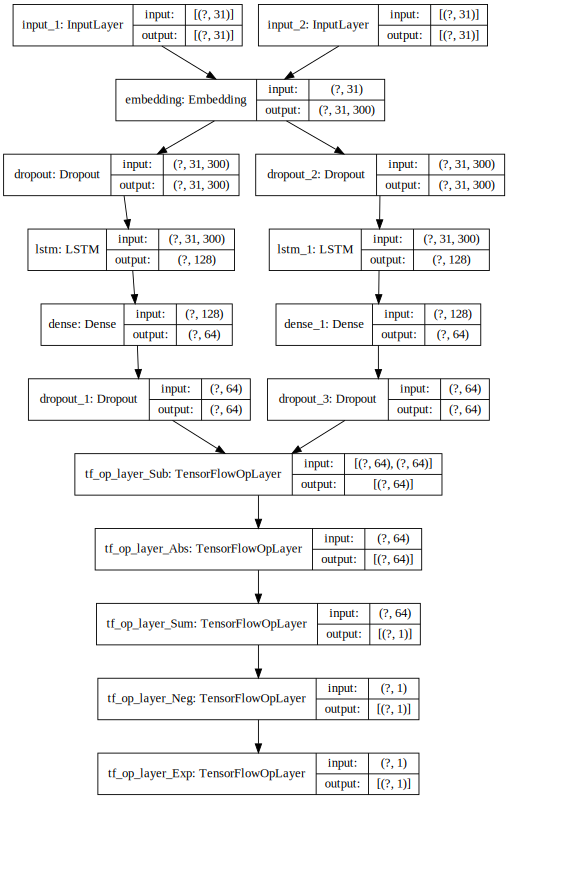

In [47]:
K.clear_session()

# LSTM 네트워크 구성
X_input_1 = Input(batch_shape=(None, X_train_1.shape[1]))
X_input_2 = Input(batch_shape=(None, X_train_2.shape[1]))

# 임베딩 : trainable = False
X_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE,
                    weights=[WE], trainable=False)

X_embed_1 = X_embed(X_input_1)
X_embed_1 = Dropout(0.2)(X_embed_1)
X_lstm_1 = LSTM(n_hidden)(X_embed_1)
X_dense_1 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_1)
X_dense_1 = Dropout(0.2)(X_dense_1)

X_embed_2 = X_embed(X_input_2)
X_embed_2 = Dropout(0.2)(X_embed_2)
X_lstm_2 = LSTM(n_hidden)(X_embed_2)
X_dense_2 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_2)
X_dense_2 = Dropout(0.2)(X_dense_2)

y_manhattan_dist = K.exp(-K.sum(K.abs(X_dense_1 - X_dense_2), axis=1, keepdims=True)) # 각 출력으로 맨하탄 거리 계산

# 모델 구성
model = Model([X_input_1, X_input_2], y_manhattan_dist)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0005))
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [48]:
# 모델 학습
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
hist = model.fit([X_train_1, X_train_2], y_train,
                 validation_data=([X_test_1, X_test_2], y_test),
                 batch_size=1000,
                 epochs=20)

Epoch 1/20
239/239 [==============================] - 11s 44ms/step - loss: 0.5701 - val_loss: 0.2875
Epoch 2/20
239/239 [==============================] - 10s 41ms/step - loss: 0.2252 - val_loss: 0.1924
Epoch 3/20
239/239 [==============================] - 10s 41ms/step - loss: 0.1877 - val_loss: 0.1863
Epoch 4/20
239/239 [==============================] - 10s 41ms/step - loss: 0.1807 - val_loss: 0.1823
Epoch 5/20
239/239 [==============================] - 10s 41ms/step - loss: 0.1769 - val_loss: 0.1776
Epoch 6/20
239/239 [==============================] - 10s 41ms/step - loss: 0.1734 - val_loss: 0.1820
Epoch 7/20
239/239 [==============================] - 10s 41ms/step - loss: 0.1704 - val_loss: 0.1836
Epoch 8/20
239/239 [==============================] - 10s 41ms/step - loss: 0.1678 - val_loss: 0.1772
Epoch 9/20
239/239 [==============================] - 10s 41ms/step - loss: 0.1648 - val_loss: 0.1776
Epoch 10/20
239/239 [==============================] - 10s 41ms/step - loss: 0.162

In [49]:
# 예측 및 결과 확인
y_pred = model.predict([X_test_1, X_test_2])
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7513018435108753


#### Fine-Tuning 진행

In [50]:
# 데이터 분리
X_train_1, X_test_1, X_train_2, X_test_2, y_train, y_test = train_test_split(q1_data, q2_data, train_labels,
                                                                             test_size=0.2,
                                                                             random_state=42)

========== 모델 전체 구조 확인 ==========
Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 31)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 31, 300)      22922100    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 31, 300)      

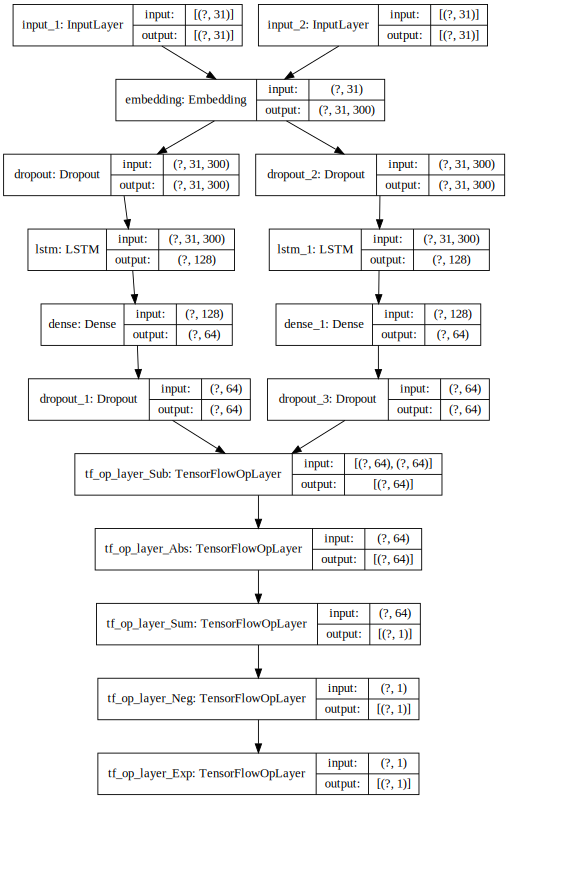

In [54]:
K.clear_session()

# LSTM 네트워크 구성
X_input_1 = Input(batch_shape=(None, X_train_1.shape[1]))
X_input_2 = Input(batch_shape=(None, X_train_2.shape[1]))

# 임베딩 : trainable = True
X_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE,
                    weights=[WE], trainable=True)

X_embed_1 = X_embed(X_input_1)
X_embed_1 = Dropout(0.2)(X_embed_1)
X_lstm_1 = LSTM(n_hidden)(X_embed_1)
X_dense_1 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_1)
X_dense_1 = Dropout(0.2)(X_dense_1)

X_embed_2 = X_embed(X_input_2)
X_embed_2 = Dropout(0.2)(X_embed_2)
X_lstm_2 = LSTM(n_hidden)(X_embed_2)
X_dense_2 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_2)
X_dense_2 = Dropout(0.2)(X_dense_2)

y_manhattan_dist = K.exp(-K.sum(K.abs(X_dense_1 - X_dense_2), axis=1, keepdims=True)) # 각 출력으로 맨하탄 거리 계산

# 모델 구성
model = Model([X_input_1, X_input_2], y_manhattan_dist)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0005))
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [55]:
# 모델 학습
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
hist = model.fit([X_train_1, X_train_2], y_train,
                 validation_data=([X_test_1, X_test_2], y_test),
                 batch_size=512,
                 epochs=50)

Epoch 1/50
467/467 [==============================] - 73s 156ms/step - loss: 0.3997 - val_loss: 0.1940
Epoch 2/50
467/467 [==============================] - 72s 153ms/step - loss: 0.1756 - val_loss: 0.1740
Epoch 3/50
467/467 [==============================] - 71s 152ms/step - loss: 0.1621 - val_loss: 0.1714
Epoch 4/50
467/467 [==============================] - 71s 153ms/step - loss: 0.1528 - val_loss: 0.1693
Epoch 5/50
467/467 [==============================] - 71s 153ms/step - loss: 0.1441 - val_loss: 0.1704
Epoch 6/50
467/467 [==============================] - 71s 153ms/step - loss: 0.1370 - val_loss: 0.1695
Epoch 7/50
467/467 [==============================] - 71s 152ms/step - loss: 0.1301 - val_loss: 0.1708
Epoch 8/50
467/467 [==============================] - 71s 153ms/step - loss: 0.1244 - val_loss: 0.1708
Epoch 9/50
467/467 [==============================] - 70s 151ms/step - loss: 0.1197 - val_loss: 0.1717
Epoch 10/50
467/467 [==============================] - 70s 151ms/step - l

In [56]:
# 예측 및 결과 확인
y_pred = model.predict([X_test_1, X_test_2])
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.7577817591212765


### 3.5. maLSTM + fastText pretrained

- Quora 데이터셋의 vocabulary 활용: `5.2` 전처리 단계에서 진행했던 tokenizer의 `word_index`.

- 가중치 벡터 만들 때
    - Glove.txt 파일 원래 생김새

In [ ]:
# 전처리 단계에서의 토크나이저 로드
with open(f"{data_path}/5-2.Quora-tokenizer.pickle", 'rb') as f:
    tokenizer = pickle.load(f)

print(tokenizer)

In [58]:
# 토크나이저의 단어로 어휘집 생성
word2idx = tokenizer.word_index
print(word2idx)

{'the': 1, 'what': 2, 'is': 3, 'how': 4, 'i': 5, 'to': 6, 'a': 7, 'in': 8, 'do': 9, 'of': 10, 'are': 11, 'and': 12, 'can': 13, 'for': 14, 'you': 15, 'why': 16, 'best': 17, 'my': 18, 'it': 19, 'on': 20, 'does': 21, 'which': 22, 'be': 23, 'if': 24, 'some': 25, 'or': 26, 'get': 27, 'that': 28, 'have': 29, 'should': 30, 'with': 31, 'your': 32, 'an': 33, 'from': 34, 'india': 35, 'will': 36, 'people': 37, 'who': 38, 'when': 39, 'good': 40, 'like': 41, 'would': 42, 'there': 43, 'at': 44, 'as': 45, 'quora': 46, 'about': 47, 'between': 48, 'one': 49, 'most': 50, 'not': 51, 'way': 52, 'we': 53, 'make': 54, 'did': 55, 'life': 56, 'by': 57, 'where': 58, 'was': 59, 'money': 60, 'any': 61, 'so': 62, 'time': 63, 'me': 64, 'after': 65, 'learn': 66, 'they': 67, 'know': 68, 'this': 69, 'whats': 70, 'difference': 71, 'has': 72, 'new': 73, 'think': 74, 'much': 75, 'trump': 76, 'ever': 77, 'use': 78, 'am': 79, 'indian': 80, 'all': 81, 'many': 82, 'their': 83, 'become': 84, 'online': 85, 'start': 86, 'us': 

In [74]:
from gensim.models import fasttext
from gensim.test.utils import datapath

In [75]:
%%time
# 사전학습된 fasttext embedding 가중치
embedding_matrix_path = f"{data_path}/weightEmbedding_fasttext.pickle"

try:
    with open(embedding_matrix_path, 'rb') as f:
        WE = pickle.load(f)
except FileNotFoundError: # 없는 경우: 사전학습된 GloVe 임베딩 벡터로부터 가중치 생성
    # model = fasttext.load_facebook_model(f"{data_path}/wiki.en.bin")
    wv = fasttext.load_facebook_vectors(datapath(f"{data_path}/wiki.en.bin"))
    WE = np.zeros((VOCAB_SIZE, EMB_SIZE))
    for word, i in word2idx.items():
        WE[i] = model.wv[word]
        # 결과 저장
        with open(embedding_matrix_path, 'wb') as f:
            pickle.dump(WE, f, pickle.HIGHEST_PROTOCOL)

AttributeError: ignored

In [ ]:
# LSTM 네트워크
n_hidden =  int(input('LSTM 은닉 노드 수 설정: '))
n_feature = int(input('latent feature 차원 수 설정: '))

In [ ]:
K.clear_session()

# LSTM 네트워크 구성
X_input_1 = Input(batch_shape=(None, X_train_1.shape[1]))
X_input_2 = Input(batch_shape=(None, X_train_2.shape[1]))

# 임베딩 : trainable = True
X_embed = Embedding(input_dim=VOCAB_SIZE, output_dim=EMB_SIZE,
                    weights=[WE], trainable=True)

X_embed_1 = X_embed(X_input_1)
X_embed_1 = Dropout(0.2)(X_embed_1)
X_lstm_1 = LSTM(n_hidden)(X_embed_1)
X_dense_1 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_1)
X_dense_1 = Dropout(0.2)(X_dense_1)

X_embed_2 = X_embed(X_input_2)
X_embed_2 = Dropout(0.2)(X_embed_2)
X_lstm_2 = LSTM(n_hidden)(X_embed_2)
X_dense_2 = Dense(n_feature, activation='relu', kernel_regularizer=l2(0.005))(X_lstm_2)
X_dense_2 = Dropout(0.2)(X_dense_2)

y_manhattan_dist = K.exp(-K.sum(K.abs(X_dense_1 - X_dense_2), axis=1, keepdims=True)) # 각 출력으로 맨하탄 거리 계산

# 모델 구성
model = Model([X_input_1, X_input_2], y_manhattan_dist)
model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.0005))
print("========== 모델 전체 구조 확인 ==========")
print(model.summary())
SVG(model_to_dot(model, show_shapes= True, show_layer_names=True, dpi=65).create(prog='dot', format='svg'))

In [ ]:
# 모델 학습
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
hist = model.fit([X_train_1, X_train_2], y_train,
                 validation_data=([X_test_1, X_test_2], y_test),
                 batch_size=512,
                 epochs=50)

In [ ]:
# loss 시각화
plt.plot(hist.history['loss'], label='Train loss')
plt.plot(hist.history['val_loss'], label = 'Test loss')
plt.legend()
plt.title("Loss Trajectory")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
# 예측 및 결과 확인
y_pred = model.predict([X_test_1, X_test_2])
y_pred = np.where(y_pred > 0.5, 1, 0)
accuracy = (y_test == y_pred).mean()
print(f"Test Accuracy: {accuracy}")